<a href="https://colab.research.google.com/github/VastSea0/nasa-hackathon/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install earthaccess

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.3/199.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 44.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.5.0
    Uninstalling tenacity-8.5.0:
      Successfully uninstalled tenacity-8.5.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2025.9.0 which i

In [2]:
import earthaccess

# 1. Login
earthaccess.login()

Enter your Earthdata Login username: egehankahraman0
Enter your Earthdata password: ··········


In [3]:
results = earthaccess.search_data(
    cloud_hosted=False,
    short_name="GPM_3IMERGHH",
    temporal=("2025-05-30", "2025-10-01"), # Güncellenmiş tarih aralığı
    bounding_box=(26, 36, 45, 42)  # Türkiye: (lon_min, lat_min, lon_max, lat_max)
)

if results:
    print(f"Bulunan veri seti sayısı: {len(results)}")
    print("İlk veri seti bilgisi:")
    display(results[0]) # display kullanarak daha okunaklı çıktı alalım
else:
    print("Belirtilen kriterlere uygun veri seti bulunamadı.")

# fetch the data

Bulunan veri seti sayısı: 96
İlk veri seti bilgisi:


Collection: {'ShortName': 'GPM_3IMERGHH', 'Version': '07'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-05-30T00:00:00.000Z', 'EndingDateTime': '2025-05-30T00:29:59.999Z'}}
Size(MB): 7.972988128662109
Data: ['https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2025/150/3B-HHR.MS.MRG.3IMERG.20250530-S000000-E002959.0000.V07B.HDF5']

Linke tıkla ve anlaşmayı kabul et

In [4]:
nsidc_url = "https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/245/3B-HHR.MS.MRG.3IMERG.20240901-S003000-E005959.0030.V07B.HDF5"
lpcloud_url = "https://data.gesdisc.earthdata.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/2024/245/3B-HHR.MS.MRG.3IMERG.20240901-S003000-E005959.0030.V07B.HDF5"

session = earthaccess.get_requests_https_session()

In [5]:
headers = {"Range": "bytes=0-100"}
r = session.get(lpcloud_url, headers=headers)
r

<Response [206]>

In [6]:
fs = earthaccess.get_fsspec_https_session()

In [7]:
with fs.open(lpcloud_url) as f:
    data = f.read(100)
data

b'\x89HDF\r\n\x1a\n\x00\x00\x00\x00\x00\x08\x08\x00\x04\x00\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff}\xb2\x82\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\x00\x00\x00\x00\x00\x00\x00\x00`\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00OHDR'

In [8]:
%%time

import xarray as xr

files = earthaccess.open(results[0:2])

ds = xr.open_dataset(files[0], group="")
ds

QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 2.12 s, sys: 165 ms, total: 2.29 s
Wall time: 11.3 s


<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    FileHeader:  DOI=10.5067/GPM/IMERG/3B-HH/07;\nDOIauthority=http://dx.doi....
    FileInfo:    DataFormatVersion=7e;\nTKCodeBuildVersion=0;\nMetadataVersio...

In [10]:
import h5py
import xarray as xr # xarray'i de dahil edelim, belki açabiliriz

# Open the first dataset found in the results list using earthaccess.open()
# We will open only the first file for inspection
if results:
    print("Opening the first dataset using earthaccess.open()...")
    try:
        # Use results[0:1] to open only the first file
        file_objects = earthaccess.open(results[0:1])

        if file_objects:
            file_obj = file_objects[0]
            print(f"Accessed file object for the first result.")

            # Attempt to list groups and variables using h5py
            print("\nAttempting to list groups and variables using h5py...")
            try:
                with h5py.File(file_obj, 'r') as f:
                    print("Contents of the HDF5 file (via h5py.visit):")
                    def print_groups_and_datasets(name):
                        print(name)
                    f.visit(print_groups_and_datasets)

            except Exception as h5py_e:
                print(f"h5py failed to open the file object: {h5py_e}")
                print("Attempting to open with xarray (if applicable)...")
                # If h5py fails, try opening with xarray (though likely to fail based on previous attempts)
                try:
                    ds_modis = xr.open_dataset(file_obj, engine="h5netcdf") # or other relevant engine
                    print("\nOpened with xarray. Variables:")
                    for var in ds_modis.variables:
                        print(var)
                    display(ds_modis)

                except Exception as xarray_e:
                    print(f"xarray also failed to open the file object: {xarray_e}")
                    print("Could not open the file object with either h5py or xarray.")
            finally:
                 # Close the file object if it has a close method
                if hasattr(file_obj, 'close'):
                    file_obj.close()

        else:
            print("earthaccess.open() did not return any file objects.")
    except Exception as e:
        print(f"Error during file access with earthaccess.open(): {e}")
else:
    print("No search results found to open.")

Opening the first dataset using earthaccess.open()...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Accessed file object for the first result.

Attempting to list groups and variables using h5py...
Contents of the HDF5 file (via h5py.visit):
Grid
Grid/Intermediate
Grid/Intermediate/IRinfluence
Grid/Intermediate/IRprecipitation
Grid/Intermediate/MWobservationTime
Grid/Intermediate/MWprecipSource
Grid/Intermediate/MWprecipitation
Grid/Intermediate/precipitationUncal
Grid/lat
Grid/lat_bnds
Grid/latv
Grid/lon
Grid/lon_bnds
Grid/lonv
Grid/nv
Grid/precipitation
Grid/precipitationQualityIndex
Grid/probabilityLiquidPrecipitation
Grid/randomError
Grid/time
Grid/time_bnds


In [15]:
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.1 MB/s eta 0:00:00


In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np # numpy'ı import edelim, kullanabiliriz

# Open the first dataset found in the results list using earthaccess.open()
# Specify the group '/Grid' as the precipitation data is inside this group
if results:
    print("Opening the first dataset using earthaccess.open() and xarray...")
    try:
        # Use results[0:1] to open only the first file
        file_objects = earthaccess.open(results[0:1])

        if file_objects:
            file_obj = file_objects[0]
            print(f"Accessed file object for the first result.")

            # Attempt to open with xarray, specifying the '/Grid' group
            print("Attempting to open with xarray, specifying the '/Grid' group...")
            try:
                # Ensure the file_obj is seekable if needed by xarray/engine
                # Using engine="netcdf4" is common for HDF5 files that are also NetCDF4 compliant
                # or simply rely on default engine if possible. Let's try default first.
                # Based on previous h5py output, variables are under /Grid
                ds_gpm = xr.open_dataset(file_obj, group="/Grid")


                # Check if the 'precipitation' variable exists
                if 'precipitation' in ds_gpm.variables:
                    precipitation_data = ds_gpm['precipitation']

                    print("\nInspecting 'precipitation' variable dimensions:")
                    print(f"Dimensions: {precipitation_data.dims}")
                    print(f"Shape: {precipitation_data.shape}")


                    # Check the number of time steps
                    if 'time' in precipitation_data.dims and precipitation_data.shape[precipitation_data.dims.index('time')] > 1:
                        print("Multiple time steps found, plotting mean precipitation over time...")
                        plt.figure(figsize=(12, 6))
                        # Plot the mean precipitation over the spatial dimensions
                        precipitation_data.mean(dim=('lat', 'lon')).plot()
                        plt.title('Ortalama Yağış Zaman Serisi')
                        plt.xlabel('Zaman')
                        plt.ylabel('Ortalama Yağış')
                        plt.grid(True)
                        plt.show()
                    elif 'lat' in precipitation_data.dims and 'lon' in precipitation_data.dims:
                         # If only one time step or no time dimension, plot a spatial map
                        print("Plotting spatial map for the first time step...")
                        plt.figure(figsize=(10, 8))
                        # Select the first (and likely only) time step for the spatial plot
                        precipitation_data.isel(time=0).plot(cmap='Blues', cbar_kwargs={'label': 'Yağış (mm/hr)'})
                        plt.title('İlk Zaman Adımında Yağış Dağılımı')
                        plt.xlabel('Boylam')
                        plt.ylabel('Enlem')
                        plt.show()
                    else:
                         print("Neither time nor spatial dimensions (lat, lon) found for plotting.")


                else:
                    print("'precipitation' variable not found in the /Grid group.")

            except Exception as xarray_e:
                print(f"xarray failed to open the dataset from /Grid group: {xarray_e}")
                print("Please check the group name and variable name based on the h5py output.")
            finally:
                 # Close the file object if it has a close method
                if hasattr(file_obj, 'close'):
                    file_obj.close()


        else:
            print("No file objects were returned by earthaccess.open().")
    except Exception as e:
        print(f"Error during file access with earthaccess.open(): {e}")
else:
    print("No search results found to open.")

Opening the first dataset using earthaccess.open() and xarray...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Accessed file object for the first result.
Attempting to open with xarray, specifying the '/Grid' group...
xarray failed to open the dataset from /Grid group: Failed to decode variable 'time': unable to decode time units 'seconds since 1980-01-06 00:00:00 UTC' with "calendar 'julian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.
Please check the group name and variable name based on the h5py output.


In [12]:
# Assuming ds_gpm is available from the previous execution of cell
if 'ds_gpm' in locals() and ds_gpm:
    print("Spatial coverage of the visualized data:")
    if 'lat' in ds_gpm.coords and 'lon' in ds_gpm.coords:
        print(f"Latitude range: {ds_gpm['lat'].min().values} to {ds_gpm['lat'].max().values}")
        print(f"Longitude range: {ds_gpm['lon'].min().values} to {ds_gpm['lon'].max().values}")
    elif 'latitude' in ds_gpm.coords and 'longitude' in ds_gpm.coords:
         print(f"Latitude range: {ds_gpm['latitude'].min().values} to {ds_gpm['latitude'].max().values}")
         print(f"Longitude range: {ds_gpm['longitude'].min().values} to {ds_gpm['longitude'].max().values}")
    else:
        print("Latitude and Longitude coordinates not found in ds_gpm.")

else:
    print("ds_gpm variable not found. Please ensure the cell opening the dataset was executed successfully.")

ds_gpm variable not found. Please ensure the cell opening the dataset was executed successfully.


In [13]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 63.2 MB/s eta 0:00:00


Opening the first dataset using earthaccess.open() and xarray...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Accessed file object for the first result.
Attempting to open with xarray, specifying the '/Grid' group...

Successfully subsetted data for Türkiye bounding box.


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


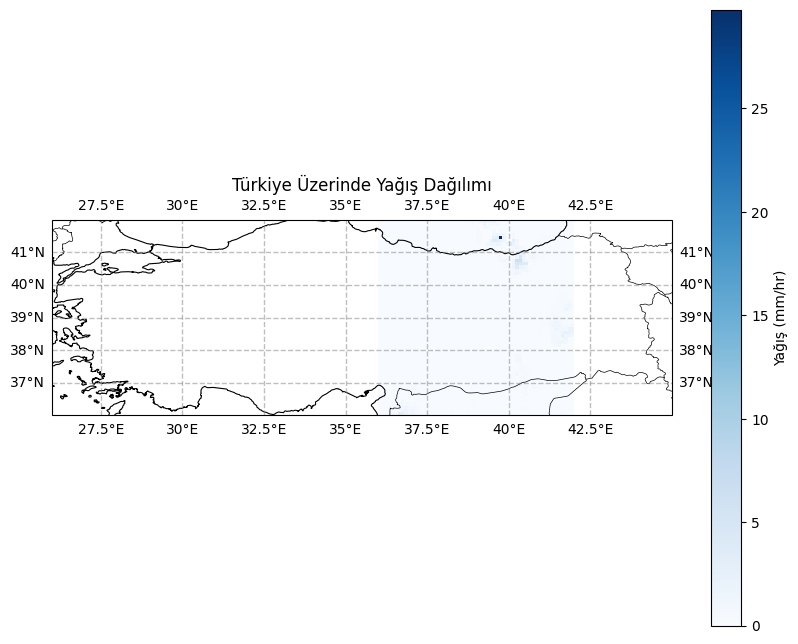

In [16]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Re-open the first dataset from results (assuming results is still available)
# Specify the group '/Grid'
if 'results' in locals() and results:
    print("Opening the first dataset using earthaccess.open() and xarray...")
    try:
        # Use results[0:1] to open only the first file
        file_objects = earthaccess.open(results[0:1])

        if file_objects:
            file_obj = file_objects[0]
            print(f"Accessed file object for the first result.")

            # Attempt to open with xarray, specifying the '/Grid' group
            print("Attempting to open with xarray, specifying the '/Grid' group...")
            try:
                ds_gpm = xr.open_dataset(file_obj, group="/Grid")

                # Check if the 'precipitation' variable exists
                if 'precipitation' in ds_gpm.variables:
                    precipitation_data = ds_gpm['precipitation']

                    # Define the Türkiye bounding box again (lon_min, lat_min, lon_max, lat_max)
                    # Using the same coordinates from k57kiY_Q4AjM
                    turkey_bbox = (26, 36, 45, 42)
                    lon_min, lat_min, lon_max, lat_max = turkey_bbox

                    # Select the data within the bounding box
                    # Note: xarray's .sel() might need coordinate names ('lon', 'lat')
                    # and the order might vary depending on the dataset.
                    # Assuming the data has 'lon' and 'lat' dimensions
                    try:
                        precipitation_subset = precipitation_data.sel(
                            lon=slice(lon_min, lon_max),
                            lat=slice(lat_min, lat_max)
                        )
                        print("\nSuccessfully subsetted data for Türkiye bounding box.")

                        # Plot the subsetted data on a map
                        plt.figure(figsize=(10, 8))
                        ax = plt.axes(projection=ccrs.PlateCarree())
                        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

                        # Add coastlines and borders
                        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
                        ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5)

                        # Plot the precipitation data subset.
                        # Use origin='lower' if lat/lon are increasing from bottom left
                        # Use cmap='Blues' for precipitation
                        precipitation_subset.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', cbar_kwargs={'label': 'Yağış (mm/hr)'})

                        # Add gridlines
                        ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

                        plt.title('Türkiye Üzerinde Yağış Dağılımı')
                        plt.show()

                    except Exception as subset_e:
                        print(f"Error subsetting or plotting data: {subset_e}")
                        print("Please check if coordinate names are 'lon' and 'lat' and their ranges.")


                else:
                    print("'precipitation' variable not found in the /Grid group.")

            except Exception as xarray_e:
                print(f"xarray failed to open the dataset from /Grid group: {xarray_e}")
                print("Please check the group name and variable name based on the h5py output.")
            finally:
                 # Close the file object if it has a close method
                if hasattr(file_obj, 'close'):
                    file_obj.close()


        else:
            print("No file objects were returned by earthaccess.open().")
    except Exception as e:
        print(f"Error during file access with earthaccess.open(): {e}")
else:
    print("results variable not found. Please run the search cell first.")

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

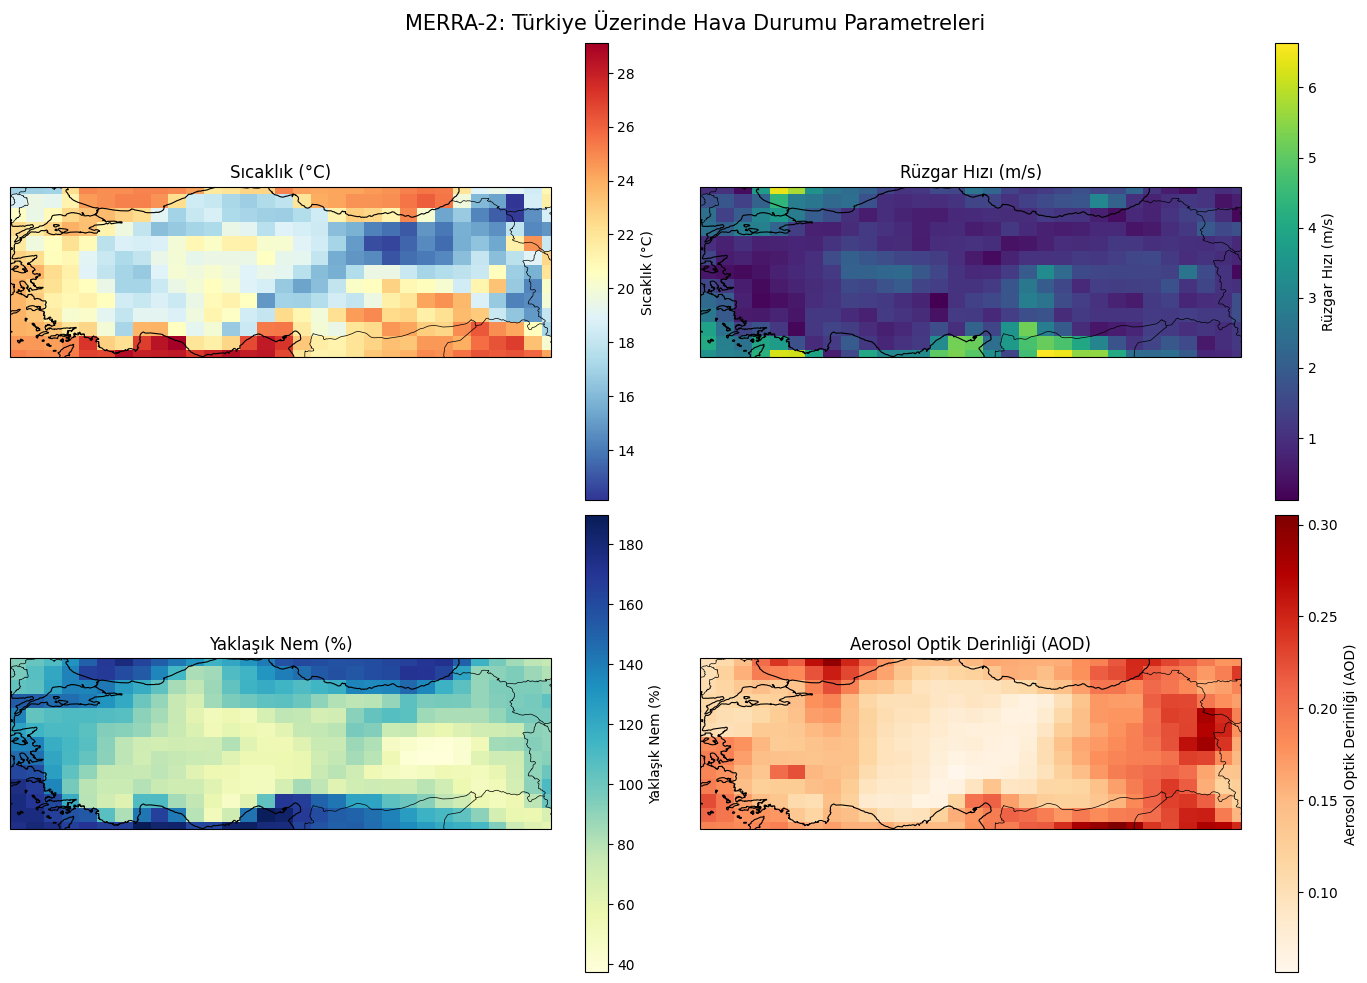

In [23]:
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- 1. Arama: MERRA-2 yüzey seviyesi (temperature, wind, humidity)
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    cloud_hosted=True,
    temporal=("2025-09-01", "2025-10-02"),
    bounding_box=(26, 36, 45, 42)
)

# --- 2. İlk dosyayı aç
file_objects = earthaccess.open(results[0:1])
ds = xr.open_dataset(file_objects[0])

# --- 3. Değişkenleri seç ve dönüştür
lon_min, lat_min, lon_max, lat_max = (26, 36, 45, 42)

# 2 metre sıcaklık (°C)
t2m = ds["T2M"].sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max)) - 273.15

# Rüzgar bileşenleri (m/s)
u2m = ds["U2M"].sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
v2m = ds["V2M"].sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# Rüzgar hızı
wind_speed = np.sqrt(u2m**2 + v2m**2)

# 2m özgül nem (kg/kg)
qv2m = ds["QV2M"].sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
# Yaklaşık bağıl nem tahmini (çok basitleştirilmiş)
relative_humidity = qv2m * 10000  # sadece görselleştirme amaçlı ölçekleme

# --- 4. Aerosol (hava kalitesi) için ayrı ürün aç
results_aer = earthaccess.search_data(
    short_name="M2T1NXAER",  # Aerosol diagnostics
    cloud_hosted=True,
    temporal=("2025-09-01", "2025-10-02"),
    bounding_box=(26, 36, 45, 42)
)
file_objects_aer = earthaccess.open(results_aer[0:1])
ds_aer = xr.open_dataset(file_objects_aer[0])
aod = ds_aer["TOTEXTTAU"].sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# --- 5. Plot: 4 panel (temperature, wind speed, humidity, aerosol)
fig, axs = plt.subplots(2, 2, figsize=(14, 10), subplot_kw={'projection': ccrs.PlateCarree()})

plots = [
    (t2m.isel(time=0), "Sıcaklık (°C)", "RdYlBu_r"),
    (wind_speed.isel(time=0), "Rüzgar Hızı (m/s)", "viridis"),
    (relative_humidity.isel(time=0), "Yaklaşık Nem (%)", "YlGnBu"),
    (aod.isel(time=0), "Aerosol Optik Derinliği (AOD)", "OrRd")
]

for ax, (data, title, cmap) in zip(axs.ravel(), plots):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,
              cbar_kwargs={'label': title})
    ax.set_title(title)

plt.suptitle("MERRA-2: Türkiye Üzerinde Hava Durumu Parametreleri", fontsize=15)
plt.tight_layout()
plt.show()


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/usr/local/lib/python3.12/dist-packages/cartopy/mpl/geoaxes.py:512: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  super()._update_title_position(renderer)
/usr/local/lib/python3.12/dist-packages/cartopy/mpl/geoaxes.py:509: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  return super().draw(renderer=renderer, **kwargs)


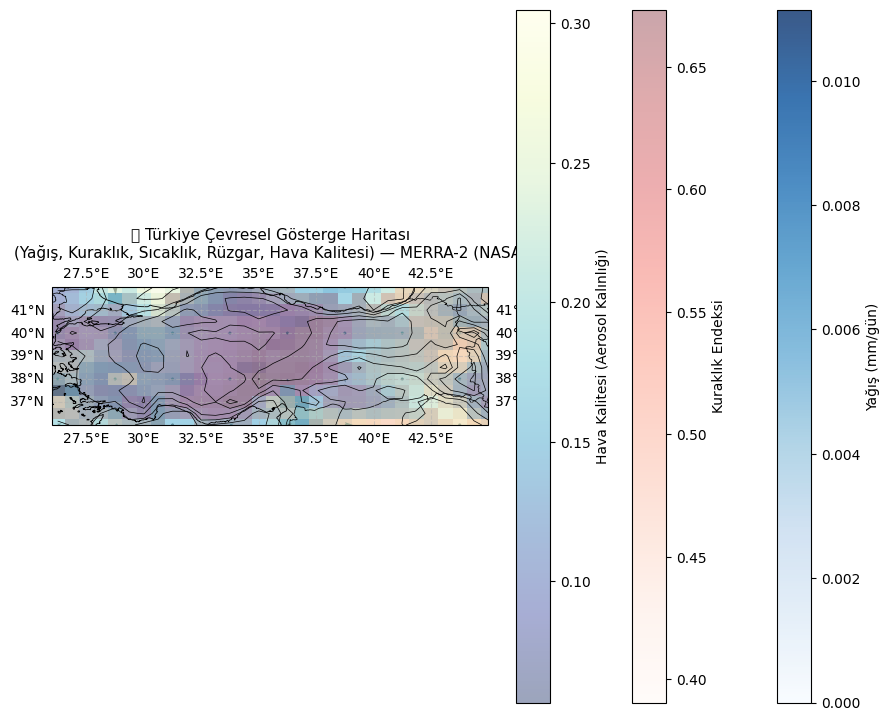

In [25]:
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

bbox = (26, 36, 45, 42)
dates = ("2025-09-01", "2025-10-02")

# 1️⃣ Atmosfer verileri (sıcaklık, rüzgar)
atm = earthaccess.search_data(short_name="M2T1NXSLV", temporal=dates, bounding_box=bbox, cloud_hosted=True)
ds_atm = xr.open_dataset(earthaccess.open(atm[0:1])[0])

# 2️⃣ Yağış (Flux dataset)
flx = earthaccess.search_data(short_name="M2T1NXFLX", temporal=dates, bounding_box=bbox, cloud_hosted=True)
ds_flx = xr.open_dataset(earthaccess.open(flx[0:1])[0])

# 3️⃣ Toprak nemi (kuraklık)
lnd = earthaccess.search_data(short_name="M2T1NXLND", temporal=dates, bounding_box=bbox, cloud_hosted=True)
ds_lnd = xr.open_dataset(earthaccess.open(lnd[0:1])[0])

# 4️⃣ Hava kalitesi
aer = earthaccess.search_data(short_name="M2T1NXAER", temporal=dates, bounding_box=bbox, cloud_hosted=True)
ds_aer = xr.open_dataset(earthaccess.open(aer[0:1])[0])

# ===================== DEĞİŞKENLER =====================
rain = ds_flx["PRECTOT"] * 1000  # mm/gün
temp = ds_atm["T2M"] - 273.15
u_wind = ds_atm["U10M"]
v_wind = ds_atm["V10M"]
soil_moist = ds_lnd["GWETROOT"]
aerosol = ds_aer["TOTEXTTAU"]

# ===================== ALTSET =====================
def subset(data):
    return data.isel(time=0).sel(lon=slice(26, 45), lat=slice(36, 42))

rain = subset(rain)
temp = subset(temp)
u_wind = subset(u_wind)
v_wind = subset(v_wind)
soil_moist = subset(soil_moist)
aerosol = subset(aerosol)

# ===================== HARİTA =====================
plt.figure(figsize=(11, 9))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([26, 45, 36, 42])
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# 1️⃣ Yağış (mavi ton)
rain.plot(ax=ax, cmap="Blues", transform=ccrs.PlateCarree(), alpha=0.8, cbar_kwargs={'label': 'Yağış (mm/gün)'})

# 2️⃣ Kuraklık (kırmızı overlay)
(1 - soil_moist).plot(ax=ax, cmap="Reds", transform=ccrs.PlateCarree(), alpha=0.35, cbar_kwargs={'label': 'Kuraklık Endeksi'})

# 3️⃣ Sıcaklık konturları
temp.plot.contour(ax=ax, colors='black', linewidths=0.5, transform=ccrs.PlateCarree())

# 4️⃣ Rüzgar okları
skip = (slice(None, None, 4), slice(None, None, 4))
ax.quiver(u_wind["lon"][skip[1]], u_wind["lat"][skip[0]], u_wind[skip], v_wind[skip], transform=ccrs.PlateCarree(), color='gray', scale=400)

# 5️⃣ Hava kalitesi
aerosol.plot(ax=ax, cmap="YlGnBu_r", transform=ccrs.PlateCarree(), alpha=0.4, cbar_kwargs={'label': 'Hava Kalitesi (Aerosol Kalınlığı)'})

plt.title("🌦 Türkiye Çevresel Gösterge Haritası\n(Yağış, Kuraklık, Sıcaklık, Rüzgar, Hava Kalitesi) — MERRA-2 (NASA)", fontsize=11)
plt.show()


In [26]:
pip install google-genai

In [28]:
!export GEMINI_API_KEY="helo"

In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
run_pipeline_fixed.py
Düzeltilmiş single-script pipeline:
- earthaccess ile NASA verilerini alır
- yağış/sıcaklık/rüzgar/toprak-nemi/aerosol hesaplar
- tek birleşik harita üretir
- Gemini'ye (varsa) analiz gönderir
Not: numpy.prod kullanıldı (numpy.product hatası düzeltildi),
ve veri yoksa güvenli fallback'ler eklendi.
"""
import os
import sys
import traceback
from datetime import datetime
import json

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

try:
    import earthaccess
except Exception:
    print("ERROR: earthaccess import failed. pip install earthaccess ve earthaccess configure yap.")
    raise

try:
    from google import genai
    from google.genai import types
except Exception:
    genai = None
    types = None

# ---------- CONFIG ----------
BBOX = (26, 36, 45, 42)
DATES = ("2025-09-01", "2025-10-02")
TIME_INDEX = 0
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------- HELPERS ----------
def search_and_open(short_name, dates=DATES, bbox=BBOX, fail_on_empty=True):
    print(f"[INFO] Searching {short_name} for {dates} @ bbox={bbox} ...")
    results = earthaccess.search_data(short_name=short_name, temporal=dates, bounding_box=bbox, cloud_hosted=True)
    if not results:
        if fail_on_empty:
            raise RuntimeError(f"No results for {short_name} {dates} {bbox}")
        return None
    files = earthaccess.open(results[0:1])
    if not files:
        raise RuntimeError(f"earthaccess.open returned no file objects for {short_name}")
    ds = xr.open_dataset(files[0])
    print(f"[INFO] Opened dataset {short_name}. Variables: {list(ds.variables.keys())[:40]} ...")
    return ds

def safe_var(ds, names):
    for n in names:
        if n in ds.variables:
            return ds[n]
    raise KeyError(f"None of {names} found. Available: {list(ds.variables.keys())[:80]}")

def subset_time_space(da, time_index=TIME_INDEX, bbox=BBOX):
    lon_min, lat_min, lon_max, lat_max = bbox
    # convert lon if in 0..360
    if 'lon' in da.coords:
        lon = da.coords['lon']
        try:
            if float(lon.max()) > 180:
                da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180)).sortby('lon')
        except Exception:
            pass
    # ensure time dimension exists
    if 'time' in da.dims:
        da = da.isel(time=time_index)
    return da.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# ---------- MAIN ----------
def build_and_plot_map(savepath=None):
    print("[STEP] Fetching datasets...")
    # open datasets (hataları yakalayacağız)
    ds_atm = search_and_open("M2T1NXSLV")
    ds_flx = search_and_open("M2T1NXFLX", fail_on_empty=False)
    ds_lnd = search_and_open("M2T1NXLND", fail_on_empty=False)
    ds_aer = search_and_open("M2T1NXAER", fail_on_empty=False)

    # SAFELY pick variables (fallbacklar)
    # Precip (flux)
    precip = None
    if ds_flx is not None:
        for cand in ["PRECTOT", "PRECTOTCORR", "PRATE", "PRECIP", "PRECC"] :
            if cand in ds_flx.variables:
                precip = ds_flx[cand]
                break

    # Temperature (mandatory)
    temp = safe_var(ds_atm, ["T2M", "TMP2m", "TEMP_2M", "T2MDEW", "T10M"])
    # Wind
    u_wind = None
    v_wind = None
    for u_c in ["U10M", "U2M", "U_10M", "U10", "U10M_AV"]:
        if u_c in ds_atm.variables:
            u_wind = ds_atm[u_c]; break
    for v_c in ["V10M", "V2M", "V_10M", "V10", "V10M_AV"]:
        if v_c in ds_atm.variables:
            v_wind = ds_atm[v_c]; break

    # soil moisture fallback
    soil = None
    if ds_lnd is not None:
        for cand in ["GWETROOT", "GWETPROF", "GWETTOP", "SOILM", "SMROOT"]:
            if cand in ds_lnd.variables:
                soil = ds_lnd[cand]; break

    # aerosol fallback
    aerosol = None
    if ds_aer is not None:
        for cand in ["TOTEXTTAU", "AOD", "AOD550", "DUEXTTAU", "DUCMASS"]:
            if cand in ds_aer.variables:
                aerosol = ds_aer[cand]; break

    # Subset time/space
    print("[STEP] Subsetting data...")
    try:
        precip_s = subset_time_space(precip) if precip is not None else None
    except Exception:
        precip_s = None
    temp_s = subset_time_space(temp) - 273.15
    u_s = subset_time_space(u_wind) if u_wind is not None else None
    v_s = subset_time_space(v_wind) if v_wind is not None else None
    soil_s = subset_time_space(soil) if soil is not None else None
    aero_s = subset_time_space(aerosol) if aerosol is not None else None

    # Derived indices
    print("[STEP] Computing derived indices...")
    wind_speed = None
    if u_s is not None and v_s is not None:
        wind_speed = np.sqrt(u_s**2 + v_s**2)

    # drought index: if soil exists, use it; else derive naive from precip
    if soil_s is not None:
        # compute a simple normalized drought index
        soil_clim = float(np.nanmean(soil_s))
        drought_index = 1.0 - (soil_s / (soil_clim + 1e-9))
        drought_index = drought_index.clip(min=0.0, max=2.0)
        drought_index = (drought_index - float(drought_index.min())) / (float(drought_index.max()) - float(drought_index.min()) + 1e-9)
    else:
        # fallback: inverted normalized precipitation (low precip -> drier)
        if precip_s is not None:
            precip_mean = float(np.nanmean(precip_s))
            # avoid division by zero:
            drought_index = 1.0 - (precip_s / (precip_mean + 1e-9))
            drought_index = drought_index.clip(min=0.0, max=2.0)
            drought_index = (drought_index - float(drought_index.min())) / (float(drought_index.max()) - float(drought_index.min()) + 1e-9)
        else:
            # final fallback: zeros
            # build a small lat/lon grid from temp_s dims
            drought_index = xr.zeros_like(temp_s) * 0.0

    # Precip conversion heuristic
    precip_mm_day = None
    if precip_s is not None:
        try:
            mean_p = float(np.nanmean(precip_s))
            if mean_p < 1e-2:
                precip_mm_day = precip_s * 86400.0
            else:
                precip_mm_day = precip_s
        except Exception:
            precip_mm_day = precip_s

    # ---------- PLOT ----------
    print("[STEP] Plotting combined map ...")
    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([BBOX[0], BBOX[2], BBOX[1], BBOX[3]], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
    ax.add_feature(cfeature.BORDERS, linewidth=0.6)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    if precip_mm_day is not None:
        im1 = precip_mm_day.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Blues", alpha=0.85, add_colorbar=False)
        cbar1 = plt.colorbar(im1, ax=ax, orientation='vertical', fraction=0.037, pad=0.02)
        cbar1.set_label("Precipitation (mm/day)")

    im2 = drought_index.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Reds", alpha=0.38, add_colorbar=False)
    cbar2 = plt.colorbar(im2, ax=ax, orientation='vertical', fraction=0.037, pad=0.1)
    cbar2.set_label("Drought index (0..1)")

    try:
        cs = temp_s.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='k', linewidths=0.6, add_colorbar=False)
        plt.clabel(cs, inline=1, fontsize=8, fmt="%1.0f°C")
    except Exception:
        pass

    try:
        if u_s is not None and v_s is not None:
            skip = (slice(None, None, 6), slice(None, None, 6))
            ax.quiver(u_s["lon"].values[skip[1]], u_s["lat"].values[skip[0]],
                      u_s.values[skip], v_s.values[skip], transform=ccrs.PlateCarree(), color='gray', scale=300)
    except Exception:
        pass

    if aero_s is not None:
        try:
            aero_img = aero_s.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="YlGnBu_r", alpha=0.25, add_colorbar=False)
            cbar3 = plt.colorbar(aero_img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.02)
            cbar3.set_label("Aerosol Optical Thickness (AOD proxy)")
        except Exception:
            pass

    title = f"Combined Environmental Map — bbox={BBOX} — {DATES[0]} to {DATES[1]}"
    plt.title(title)
    outpath = os.path.join(OUTPUT_DIR, f"combined_map_{datetime.utcnow().strftime('%Y%m%dT%H%M%S')}.png")
    plt.savefig(outpath, dpi=220, bbox_inches='tight')
    plt.close(fig)
    print(f"[OK] saved map to: {outpath}")

    # ---------- SUMMARY ----------
    print("[STEP] Building analysis summary ...")
    summary = {}
    if precip_mm_day is not None:
        try:
            mean_precip = float(np.nanmean(precip_mm_day))
            # use np.prod correctly
            total_cells = int(np.prod(precip_mm_day.shape))
            prob_rain = float(np.sum(precip_mm_day.values > 1.0) / max(total_cells, 1))
            summary['precip_mean_mm_per_day'] = round(mean_precip, 3)
            summary['precip_prob_gt_1mm'] = round(prob_rain, 3)
        except Exception:
            summary['precip_mean_mm_per_day'] = None
            summary['precip_prob_gt_1mm'] = None
    else:
        summary['precip_mean_mm_per_day'] = None
        summary['precip_prob_gt_1mm'] = None

    summary['temp_mean_C'] = round(float(np.nanmean(temp_s)), 2) if temp_s is not None else None
    summary['wind_mean_m_s'] = round(float(np.nanmean(wind_speed)), 2) if wind_speed is not None else None
    summary['drought_index_mean'] = round(float(np.nanmean(drought_index)), 3) if drought_index is not None else None
    summary['aod_mean'] = round(float(np.nanmean(aero_s)), 3) if aero_s is not None else None

    summary['map_path'] = outpath
    summary['bbox'] = BBOX
    summary['dates'] = DATES

    print("[DONE] analysis summary:", json.dumps(summary, indent=2))
    return summary

# ---------- GEMINI ----------
def call_gemini_with_analysis(analysis_dict, model_name="gemini-2.5-flash-lite", thinking_budget=0):
    if genai is None or types is None:
        print("[WARN] google-genai not installed/importable. Skipping Gemini call.")
        return None
    api_key = "did you think that i forgot my api key here, arenot you?"
    if not api_key:
        print("[WARN] GEMINI_API_KEY not set. Skipping Gemini call.")
        return None

    client = genai.Client(api_key=api_key)
    user_text = f"""Numeric analysis for bbox={analysis_dict.get('bbox')} dates={analysis_dict.get('dates')}:
{json.dumps(analysis_dict, indent=2)}
Please produce: 1) 3-sentence summary 2) risk bullets (agri/health/transport) 3) 3 actionable recommendations. Format as JSON with keys: summary, risks, recommendations.
"""
    contents = [ types.Content(role="user", parts=[ types.Part.from_text(text=user_text) ]) ]
    generate_content_config = types.GenerateContentConfig(
        thinking_config = types.ThinkingConfig(thinking_budget=thinking_budget),
        tools = []
    )

    print("[LLM] Sending to Gemini:", model_name)
    collected = ""
    for chunk in client.models.generate_content_stream(model=model_name, contents=contents, config=generate_content_config):
        text = getattr(chunk, "text", None)
        if text:
            print(text, end="", flush=True)
            collected += text
    print("\n[LLM] Done.")
    return collected

# ---------- ENTRY ----------
def main():
    try:
        summary = build_and_plot_map()
    except Exception:
        print("[ERROR] Pipeline failed. Traceback follows:")
        traceback.print_exc()
        return

    try:
        llm_text = call_gemini_with_analysis(summary)
        if llm_text:
            llm_out = os.path.join(OUTPUT_DIR, "gemini_analysis.txt")
            with open(llm_out, "w", encoding="utf-8") as f:
                f.write(llm_text)
            print("[OK] Gemini analysis saved to:", llm_out)
        else:
            print("[INFO] Gemini not used or failed. Map file:", summary.get("map_path"))
    except Exception:
        print("[WARN] Gemini call crashed. Traceback:")
        traceback.print_exc()
        print("Map file:", summary.get("map_path"))

if __name__ == "__main__":
    main()


[STEP] Fetching datasets...
[INFO] Searching M2T1NXSLV for ('2025-09-01', '2025-10-02') @ bbox=(26, 36, 45, 42) ...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Opened dataset M2T1NXSLV. Variables: ['CLDPRS', 'CLDTMP', 'DISPH', 'H1000', 'H250', 'H500', 'H850', 'OMEGA500', 'PBLTOP', 'PS', 'Q250', 'Q500', 'Q850', 'QV10M', 'QV2M', 'SLP', 'T10M', 'T250', 'T2M', 'T2MDEW', 'T2MWET', 'T500', 'T850', 'TO3', 'TOX', 'TQI', 'TQL', 'TQV', 'TROPPB', 'TROPPT', 'TROPPV', 'TROPQ', 'TROPT', 'TS', 'U10M', 'U250', 'U2M', 'U500', 'U50M', 'U850'] ...
[INFO] Searching M2T1NXFLX for ('2025-09-01', '2025-10-02') @ bbox=(26, 36, 45, 42) ...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Opened dataset M2T1NXFLX. Variables: ['BSTAR', 'CDH', 'CDM', 'CDQ', 'CN', 'DISPH', 'EFLUX', 'EVAP', 'FRCAN', 'FRCCN', 'FRCLS', 'FRSEAICE', 'GHTSKIN', 'HFLUX', 'HLML', 'NIRDF', 'NIRDR', 'PBLH', 'PGENTOT', 'PRECANV', 'PRECCON', 'PRECLSC', 'PRECSNO', 'PRECTOT', 'PRECTOTCORR', 'PREVTOT', 'QLML', 'QSH', 'QSTAR', 'RHOA', 'RISFC', 'SPEED', 'SPEEDMAX', 'TAUGWX', 'TAUGWY', 'TAUX', 'TAUY', 'TCZPBL', 'TLML', 'TSH'] ...
[INFO] Searching M2T1NXLND for ('2025-09-01', '2025-10-02') @ bbox=(26, 36, 45, 42) ...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Opened dataset M2T1NXLND. Variables: ['BASEFLOW', 'ECHANGE', 'EVLAND', 'EVPINTR', 'EVPSBLN', 'EVPSOIL', 'EVPTRNS', 'FRSAT', 'FRSNO', 'FRUNST', 'FRWLT', 'GHLAND', 'GRN', 'GWETPROF', 'GWETROOT', 'GWETTOP', 'LAI', 'LHLAND', 'LWLAND', 'PARDFLAND', 'PARDRLAND', 'PRECSNOLAND', 'PRECTOTLAND', 'PRMC', 'QINFIL', 'RUNOFF', 'RZMC', 'SFMC', 'SHLAND', 'SMLAND', 'SNODP', 'SNOMAS', 'SPLAND', 'SPSNOW', 'SPWATR', 'SWLAND', 'TELAND', 'TPSNOW', 'TSAT', 'TSOIL1'] ...
[INFO] Searching M2T1NXAER for ('2025-09-01', '2025-10-02') @ bbox=(26, 36, 45, 42) ...


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Opened dataset M2T1NXAER. Variables: ['BCANGSTR', 'BCCMASS', 'BCEXTTAU', 'BCFLUXU', 'BCFLUXV', 'BCSCATAU', 'BCSMASS', 'DMSCMASS', 'DMSSMASS', 'DUANGSTR', 'DUCMASS', 'DUCMASS25', 'DUEXTT25', 'DUEXTTAU', 'DUFLUXU', 'DUFLUXV', 'DUSCAT25', 'DUSCATAU', 'DUSMASS', 'DUSMASS25', 'OCANGSTR', 'OCCMASS', 'OCEXTTAU', 'OCFLUXU', 'OCFLUXV', 'OCSCATAU', 'OCSMASS', 'SO2CMASS', 'SO2SMASS', 'SO4CMASS', 'SO4SMASS', 'SSANGSTR', 'SSCMASS', 'SSCMASS25', 'SSEXTT25', 'SSEXTTAU', 'SSFLUXU', 'SSFLUXV', 'SSSCAT25', 'SSSCATAU'] ...
[STEP] Subsetting data...
[STEP] Computing derived indices...
[STEP] Plotting combined map ...


/tmp/ipython-input-1304104572.py:219: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  outpath = os.path.join(OUTPUT_DIR, f"combined_map_{datetime.utcnow().strftime('%Y%m%dT%H%M%S')}.png")


[OK] saved map to: output/combined_map_20251004T195326.png
[STEP] Building analysis summary ...
[DONE] analysis summary: {
  "precip_mean_mm_per_day": 0.023,
  "precip_prob_gt_1mm": 0.0,
  "temp_mean_C": 20.61,
  "wind_mean_m_s": 2.48,
  "drought_index_mean": 0.211,
  "aod_mean": 0.155,
  "map_path": "output/combined_map_20251004T195326.png",
  "bbox": [
    26,
    36,
    45,
    42
  ],
  "dates": [
    "2025-09-01",
    "2025-10-02"
  ]
}
[LLM] Sending to Gemini: gemini-2.5-flash-lite
```json
{
  "summary": "Over the period of September 1st to October 2nd, 2025, the analyzed region is projected to experience generally mild weather with an average temperature of 20.61°C and moderate wind speeds of 2.48 m/s. Precipitation is expected to be very low, with a mean of 0.023 mm per day and no significant probability of exceeding 1 mm. The atmospheric conditions suggest a low risk of widespread environmental concerns, as indicated by a low mean drought index and moderate aerosol optical de